## Learning with Massive Data
### Assignment 2 - Studying Sparse-Dense Retrieval
#### Giovanni Costa - 880892

Contents:
- [Sparse representation](#s_repr)
- [Dense representation](#d_repr)
- [Top k retrieval](#exact_retr)
- [Top k\' retrieval (approximate case)](#approx_retr)
- [Evaluations](#eval)

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import words
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data_dir="datasets/"
dataset1_name_dir="trec-covid/"
dataset2_name_dir="scifact/"

In [2]:
corpus_df1=pd.read_json(data_dir+dataset1_name_dir+"corpus.jsonl", lines=True)
queries_df1=pd.read_json(data_dir+dataset1_name_dir+"queries.jsonl", lines=True)

In [ ]:
corpus_df1.info()

In [ ]:
corpus_df1.head(2)

In [ ]:
queries_df1.info()

In [ ]:
queries_df1.head(2)

In [3]:
corpus_df2=pd.read_json(data_dir+dataset2_name_dir+"corpus.jsonl", lines=True)
queries_df2=pd.read_json(data_dir+dataset2_name_dir+"queries.jsonl", lines=True)

In [ ]:
corpus_df2.info()

In [ ]:
corpus_df2.head(2)

In [ ]:
queries_df2.info()

In [ ]:
queries_df2.head(2)

<a id='s_repr'></a>
### Sparse representation

In [ ]:
#Sk-learn's "TfidfVectorizer" and "CountVectorizer" extension to provide the stemming feature
class StemmedTfidfVectorizer(TfidfVectorizer):
    stemmer = PorterStemmer()
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (StemmedTfidfVectorizer.stemmer.stem(w) for w in analyzer(doc))
    
class StemmedTfidfCountVectorizer(CountVectorizer):
    stemmer = PorterStemmer()
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: (StemmedTfidfCountVectorizer.stemmer.stem(w) for w in analyzer(doc))
    
    
def compute_sparse_repr(vocab: np.array, corpus: pd.DataFrame, queries: pd.DataFrame):
    #Extract only the word and the numbers, made a lowercase transformation and usage of custom vocabulary to make representations independent
    doc_tfidf=StemmedTfidfVectorizer(lowercase=True, vocabulary=vocab, stop_words=None, token_pattern=r'\w+')
    q_counter=StemmedTfidfCountVectorizer(lowercase=True, vocabulary=vocab, stop_words=None, token_pattern=r'\w+')

    #Computation of the sparse embedding
    sparse_doc=doc_tfidf.fit_transform(corpus["text"])
    sparse_q=q_counter.fit_transform(queries["text"])

    return sparse_doc, sparse_q

In [ ]:
#Stem the vocabulary and drop the duplicates
stemmer=PorterStemmer()
vocab=np.unique([stemmer.stem(w) for w in np.char.lower(words.words())])

In [ ]:
sparse_doc, sparse_q=compute_sparse_repr(vocab, corpus_df1, queries_df1)

#Here it's basically computed sparse_score=<q_sparse, d_sparse>
sparse_score_df=pd.DataFrame(np.dot(sparse_q, sparse_doc.transpose()).toarray(), index=queries_df1["_id"], columns=corpus_df1["_id"])
sparse_score_df.to_parquet("sparse_score_df_"+dataset1_name_dir.split("/")[0]+".parquet")

In [ ]:
sparse_doc, sparse_q=compute_sparse_repr(vocab, corpus_df2, queries_df2)

#Here it's basically computed sparse_score=<q_sparse, d_sparse>
sparse_score_df=pd.DataFrame(np.dot(sparse_q, sparse_doc.transpose()).toarray(), index=queries_df2["_id"], columns=corpus_df2["_id"])
sparse_score_df.to_parquet("sparse_score_df_"+dataset2_name_dir.split("/")[0]+".parquet")

<a id='d_repr'></a>
### Dense representation

In [ ]:
def compute_dense_repr(corpus: pd.DataFrame, queries: pd.DataFrame):
    transformers = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    ##Computation of the dense embedding
    dense_c=transformers.encode(corpus["text"], convert_to_numpy = True)
    dense_q=transformers.encode(queries["text"], convert_to_numpy = True)
    
    return dense_c, dense_q

In [ ]:
dense_c, dense_q=compute_dense_repr(corpus_df1, queries_df1)

#Here it's basically computed dense_score=<q_dense, d_dense>
dense_score_df=pd.DataFrame(np.dot(dense_q, dense_c.transpose()), index=queries_df1["_id"], columns=corpus_df1["_id"])
dense_score_df.to_parquet("dense_score_df_"+dataset1_name_dir.split("/")[0]+".parquet")

In [ ]:
dense_c, dense_q=compute_dense_repr(corpus_df2, queries_df2)

#Here it's basically computed dense_score=<q_dense, d_dense>
dense_score_df=pd.DataFrame(np.dot(dense_q, dense_c.transpose()), index=queries_df2["_id"], columns=corpus_df2["_id"])
dense_score_df.to_parquet("dense_score_df_"+dataset2_name_dir.split("/")[0]+".parquet")

<a id='exact_retr'></a>
## Top k retrieval

In [4]:
sparse_score_df1=pd.read_parquet("sparse_score_df_"+dataset1_name_dir.split("/")[0]+".parquet")
dense_score_df1=pd.read_parquet("dense_score_df_"+dataset1_name_dir.split("/")[0]+".parquet")

In [5]:
sparse_score_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1 to 50
Columns: 171332 entries, ug7v899j to pnl9th2c
dtypes: float32(171332)
memory usage: 32.7 MB


In [6]:
dense_score_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1 to 50
Columns: 171332 entries, ug7v899j to pnl9th2c
dtypes: float32(171332)
memory usage: 32.7 MB


In [7]:
sparse_score_df2=pd.read_parquet("sparse_score_df_"+dataset2_name_dir.split("/")[0]+".parquet")
dense_score_df2=pd.read_parquet("dense_score_df_"+dataset2_name_dir.split("/")[0]+".parquet")

In [8]:
sparse_score_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1109 entries, 0 to 1395
Columns: 5183 entries, 4983 to 198309074
dtypes: float32(5183)
memory usage: 21.9 MB


In [9]:
dense_score_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1109 entries, 0 to 1395
Columns: 5183 entries, 4983 to 198309074
dtypes: float32(5183)
memory usage: 21.9 MB


In [10]:
def compute_sorted_indexes(sparse_score_df: pd.DataFrame, dense_score_df: pd.DataFrame, total_score_df: pd.DataFrame):
    idx_sparse=np.argsort(sparse_score_df)
    idx_dense=np.argsort(dense_score_df)
    idx_total=np.argsort(total_score_df)
    return idx_sparse, idx_dense, idx_total

def compute_exact_retrieval(total_score_df: pd.DataFrame, idx_total: np.array, k: int):
    #Get the exact top-k documents indexes
    idx_exact_top_k=idx_total[:, :-k-1:-1]
    #Get the exact top-k documents ids
    top_k_exact_docs=np.array(total_score_df.columns[idx_exact_top_k.reshape(-1)]).reshape(-1, k)
    
    return top_k_exact_docs

In [11]:
k=5
total_score_df1=sparse_score_df1+dense_score_df1 #sum the two scores df
#Compute the sorted list of relevant score indexes to speed up the next top-k or top-k' retrievals
idx_sparse_df1, idx_dense_df1, idx_total_df1=compute_sorted_indexes(sparse_score_df1, dense_score_df1, total_score_df1)
top_k_exact_docs_df1=compute_exact_retrieval(total_score_df1, idx_total_df1, k)

In [12]:
total_score_df1.head(2)

_id,ug7v899j,02tnwd4m,ejv2xln0,2b73a28n,9785vg6d,zjufx4fo,5yhe786e,8zchiykl,8qnrcgnk,jg13scgo,...,fvhq8yud,plp5sxyl,cpgcp7cs,yz0buegp,08gqn86z,7e8r61e7,6jittbis,hi8k8wvb,ma3ndg41,pnl9th2c
_id,,,,,,,,,,,,,,,,,,,,,
1,0.453372,0.584910,0.582493,0.345679,0.544013,0.600357,0.190219,0.496787,0.248941,0.388101,...,-0.016971,0.812093,0.686764,0.599872,0.551895,-0.016971,0.204954,0.398401,1.134267,-0.016971
2,0.514232,0.637419,0.680840,0.360693,0.862798,0.771147,0.510018,0.422742,0.492347,0.695964,...,0.016533,0.886815,0.978100,0.691514,0.811774,0.016533,0.450004,0.711241,1.040751,0.016533


In [13]:
top_k_exact_docs_df1[0]

array(['dv9m19yk', 'vpodtbjk', '76gbhh40', '75773gwg', 'sjyrr2bn'],
      dtype=object)

In [14]:
k=5
total_score_df2=sparse_score_df2+dense_score_df2 #sum the two scores df
#Compute the sorted list of relevant score indexes to speed up the next top-k or top-k' retrievals
idx_sparse_df2, idx_dense_df2, idx_total_df2=compute_sorted_indexes(sparse_score_df2, dense_score_df2, total_score_df2)
top_k_exact_docs_df2=compute_exact_retrieval(total_score_df2, idx_total_df2, k)

In [15]:
total_score_df2.head(2)

_id,4983,5836,7912,18670,19238,33370,36474,54440,70115,70490,...,167944455,168265642,195317463,195680777,195683603,195689316,195689757,196664003,198133135,198309074
_id,,,,,,,,,,,,,,,,,,,,,
0,0.173609,0.074928,0.100784,0.064549,0.061095,0.084592,0.161269,0.015956,-0.005350,-0.095452,...,0.136015,0.065667,-0.093384,0.013274,0.042026,-0.052650,-0.016264,0.132296,-0.033341,-0.032738
2,0.239761,0.060025,0.140355,0.346917,0.306274,0.253765,0.184418,0.296677,0.255463,0.310669,...,0.334734,0.281085,0.319543,0.167405,-0.067490,0.290175,0.056888,0.010967,0.412197,0.362381


In [16]:
top_k_exact_docs_df2[0]

array([10786948,   825728, 17388232,  7581911, 10607877], dtype=int64)

<a id='approx_retr'></a>
## Top k' retrieval (approximate case)

In [17]:
def compute_approx_retrieval(idx_sparse: np.array, idx_dense: np.array, total_score_df: pd.DataFrame, k: int, k_prime: int):
    
    #Get the indexes of top-k' docs for the sparse representations
    idx_sparse_scores=idx_sparse[:, :-k_prime-1:-1]
    #Get the indexes of top-k' docs for the dense representations
    idx_dense_scores=idx_dense[:, :-k_prime-1:-1]

    #Merging of the two vectors of indexes
    concat_idx=np.concatenate((idx_sparse_scores, idx_dense_scores), axis=1)
    #Drop duplicates in every row
    union_idx=[np.unique(x) for x in concat_idx]
    
    #Get the indexes of the top-k documents given the merged approximate sets:
    #for every query, take the top-k indexes using the specific column indexes of the merged set, based on total_score computed previous
    idx_approx_top_k=np.asarray([ union_idx[i][np.argsort(total_score_df.iloc[i, union_idx[i]])[:-k-1:-1].values]
                                  for i in range(len(union_idx)) ])
    
    
    #Get the doc ids from the retrieved indexes
    top_k_approx_docs=np.array(total_score_df.columns[idx_approx_top_k.reshape(-1)]).reshape(-1, k)

    return top_k_approx_docs

In [18]:
top_k_approx_docs_df1=compute_approx_retrieval(idx_sparse_df1, idx_dense_df1, total_score_df1, k, k)

In [19]:
top_k_approx_docs_df1[0]

array(['dv9m19yk', '7nhnds83', 'mm4ngrla', '1loqavom', 'euv03cul'],
      dtype=object)

In [20]:
top_k_approx_docs_df2=compute_approx_retrieval(idx_sparse_df2, idx_dense_df2, total_score_df2, k, k)

In [21]:
top_k_approx_docs_df2[0]

array([10786948, 17388232, 29638116, 10906636,   994800], dtype=int64)

<a id='eval'></a>
## Evaluations

In [34]:
def evaluation_fun(total_score_df: pd.DataFrame, 
                   idx_sparse: np.array, idx_dense: np.array, idx_total: np.array,                   
                   corpus_len: int, k_list: list, step:int=1, epsilon:float=0.01):
    mean_recalls_list=[list() for i in range(len(k_list))]
    top_k_exact_approx_lists=[list() for i in range(len(k_list))]
    max_k_prime_list=[]
    i=0
    for k in k_list:
        top_k_exact_docs=compute_exact_retrieval(total_score_df, idx_total, k)
        for k_prime in range(k, corpus_len+1, step):
            top_k_approx_docs=compute_approx_retrieval(idx_sparse, idx_dense, total_score_df, k, k_prime)
            recalls=[len(np.intersect1d(top_k_exact_docs[i], top_k_approx_docs[i], assume_unique=True))/k for i in range(len(top_k_exact_docs))]
            mean=np.mean(recalls)
            mean_recalls_list[i].append(mean)

            if mean>=1-epsilon or k==corpus_len:
                print(k_prime)
                max_k_prime_list.append(k_prime)
                break
        i+=1
    
    return mean_recalls_list, top_k_exact_approx_lists, max_k_prime_list


In [54]:
def print_plot(k_list, mean_recalls_list, max_k_prime_list, step=1):
    plt.figure(figsize=(7, 5))
    plt.ylabel('Recall scores')
    plt.xlabel('K\' values')
    plt.ylim(np.min(np.concatenate(mean_recalls_list)), 1)
    plt.hlines(np.max(np.concatenate(mean_recalls_list)), np.min(k_list), np.max(max_k_prime_list), linewidth=2, linestyles="dashed", colors="grey")

    for i in range(len(k_list)):    
        plt.plot(range(k_list[i], max_k_prime_list[i]+1, step), mean_recalls_list[i], linewidth=2, label="k="+str(k_list[i]))
    plt.grid()
    plt.legend()
    plt.show()

In [36]:
k_list=[5, 50, 100, 200]
mean_recalls_list_df1, top_k_exact_approx_lists_df1, max_k_prime_list_df1=evaluation_fun(total_score_df1, idx_sparse_df1, idx_dense_df1, idx_total_df1, len(corpus_df1), k_list)

32
168
285
489


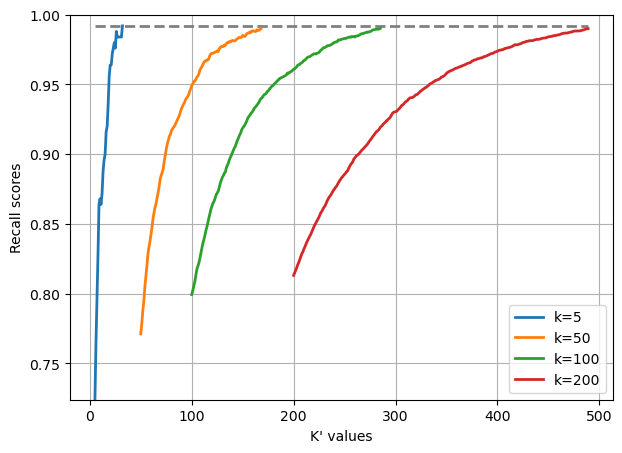

In [55]:
print_plot(k_list, mean_recalls_list_df1, max_k_prime_list_df1)

In [40]:
for i in range(len(k_list)):
    print("K: ", k_list[i])
    idx=np.argmax(mean_recalls_list_df1[i])
    print("Exit threshold: ", 1-0.01)
    print("Highest recall w.r.t. exact solution: ", mean_recalls_list_df1[i][idx], ",")
    print("obtained with k\': ", max_k_prime_list_df1[i])
    print()


K:  5
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.992 ,
obtained with k':  32

K:  50
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.99 ,
obtained with k':  168

K:  100
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.9902000000000001 ,
obtained with k':  285

K:  200
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.99 ,
obtained with k':  489



In [38]:
mean_recalls_list_df2, top_k_exact_approx_lists_df2, max_k_prime_list_df2=evaluation_fun(total_score_df2, idx_sparse_df2, idx_dense_df2, idx_total_df2, len(corpus_df2), k_list)

17
107
184
315


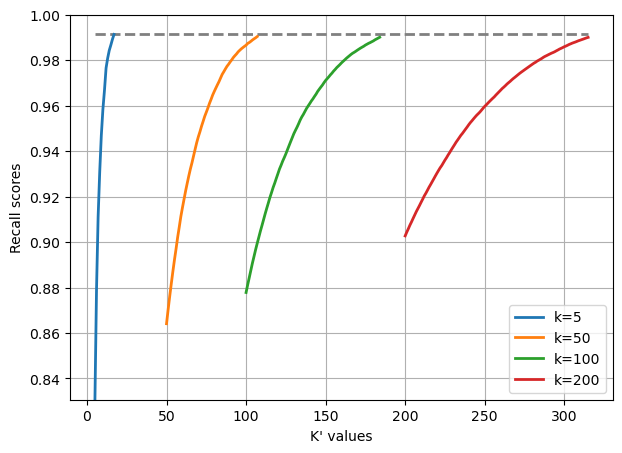

In [56]:
print_plot(k_list, mean_recalls_list_df2, max_k_prime_list_df2)

In [41]:
for i in range(len(k_list)):
    print("K: ", k_list[i])
    idx=np.argmax(mean_recalls_list_df2[i])
    print("Exit threshold: ", 1-0.01)
    print("Highest recall w.r.t. exact solution: ", mean_recalls_list_df2[i][idx], ",")
    print("obtained with k\': ", max_k_prime_list_df2[i])
    print()


K:  5
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.9913435527502256 ,
obtained with k':  17

K:  50
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.9903877366997296 ,
obtained with k':  107

K:  100
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.9900901713255187 ,
obtained with k':  184

K:  200
Exit threshold:  0.99
Highest recall w.r.t. exact solution:  0.9900360685302072 ,
obtained with k':  315

